# Gaussian process model checking: test cases

Here we test model checking diagnostics patterned after Bastos-O'Hagen:

<div>
    Leonardo S. Bastos and Anthony O'Hagan, 
    <a href="https://doi.org/10.1198/TECH.2009.08019"> <i>Diagnostics for Gaussian Process Emulators</i> </a>,
    Technometrics <b>51</b>, 425 (2009).
</div>

The diagnostic functions are from the <a href="https://github.com/jordan-melendez/gsum">gsum module</a> written by Jordan Melendez.

Last revised 11-Dec-2018 by Dick Furnstahl [furnstahl.1@osu.edu], building on the original notebook by Jordan Melendez and modifications by Daniel Phillips. 

## Overview of B&O Model Checking Implementation

Bastos & O'Hagan provide a versatile set of diagnostic tools for testing whether or not a Gaussian process (GP) is a reasonable emulator for an expensive simulator. Our use case is slightly different than theirs. We don't necessarily care about our GPs matching some underlying simulator. Rather, given a set of curves from a hierarchy of simulators, we wish to answer the following questions:
1. Can they reasonably be assumed to be drawn from the same underlying Gaussian process?
2. If so, which Gaussian process?
3. The underlying GP is later used as a model discrepancy, so how can we test its performance against experiment?

These three questions may or may not be decided by diagnostics discussed in B&O, but to find out we must implement their methods!
This notebook tests our adaptations of their methods.

## Modules to import

(rjf note: imports in the original notebook that were moved to gsum have been removed.)

In [2]:
# standard python: see online documentation
import numpy as np
import scipy as sp

# For plotting we use matplotlib; other choices are possible
import matplotlib as mpl
import matplotlib.pyplot as plt

# special imports for python programming: see online documentation
from itertools import cycle

# scikit-learn machine learning  https://scikit-learn.org/stable/modules/classes.html
from sklearn.gaussian_process import GaussianProcessRegressor
   # see https://scikit-learn.org/stable/modules/gaussian_process.html
   #  for documentation. Main excerpt:
   # The GaussianProcessRegressor implements Gaussian processes (GP) for 
   #  regression purposes. For this, the prior of the GP needs to be specified. 
   #  The prior mean is assumed to be constant and zero (for normalize_y=False) 
   #  or the training data’s mean (for normalize_y=True). 
   #  The prior’s covariance is specified by passing a kernel object. 
   #  The hyperparameters of the kernel are optimized during fitting of 
   #  GaussianProcessRegressor by maximizing the log-marginal-likelihood (LML) 
   #  based on the passed optimizer. If the initial hyperparameters should be kept 
   #  fixed, None can be passed as optimizer.
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
   # RBF is a particular GP kernel (radial-basis function kernel, aka 
   #  squared-exponential kernel).
   # ConstantKernel: "Can be used as part of a product-kernel where it scales the 
   #  magnitude of the other factor (kernel) or as part of a sum-kernel, where it 
   #  modifies the mean of the Gaussian process."
   # WhiteKernel: "The main use-case of this kernel is as part of a sum-kernel where 
   #  it explains the noise-component of the signal. Tuning its parameter corresponds 
   #  to estimating the noise-level."

# gsum is the package written by Jordan Melendez
import gsum
from gsum import rbf, default_attributes, cholesky_errors, mahalanobis
from gsum import lazy_property, pivoted_cholesky
from gsum import ConjugateGaussianProcess, ConjugateStudentProcess
from gsum import Diagnostic, GraphicalDiagnostic


In [3]:
# set rcParams here
mpl.rcParams['figure.dpi'] = 120

In [4]:
%matplotlib inline

## Test case 

This test case will generate toy data from the same given GP by sampling a few curves and selecting a set of training points from each curve.  Then we fit a GP to the data. 



### Class definition for model checking of a toy model

In [5]:
from math import ceil

class Toy_model:
    """Toy model for GP model checking based on Bastos & O'Hagan.
        Uses functions from the gsum package by Jordan Melendez.
    """
    def __init__(self,
                 name = '[unnamed]',
                 x_min = 0,
                 x_max = 20,
                 x_num = 21,
                 data_skip = 5,
                 data_offset = 0,   # should be less than data_skip
                 n_samples = 4,
                 n_ref = 1000,
                 basevar = 1.0,
                 varshiftfactor = 1.0,
                 baselengthscale = 3.0,
                 lengthscaleshift = 0.0,
                 seed = 2,
                 nugget_sd = 1e-4,
                 vlines = True,
                 print_level = 1
                ):
        """Specify the toy model by the range and number of points, which 
            points are used for training, how many gp curves are sampled and 
            with what gp hyperparameters, and what seed and nugget are used.
        """
        self.name = name
        
        # mesh points for the GPs (x_num points from x_min to x_max)
        self.x_min = x_min
        self.x_max = x_max
        self.x_num = x_num
        self.X_full = np.atleast_2d(np.linspace(self.x_min, self.x_max, self.x_num)).T

        # toy data points (every data_skip points starting with data_offset point)
        self.data_skip = data_skip
        self.data_offset = data_offset  
        self.data_pts = ceil(x_num/data_skip)
        # mask array True entry if corresponding point is in training data, otherwise False 
        self.mask = np.array([(i-self.data_offset) % self.data_skip == 0 \
                              for i in range(len(self.X_full))])

        self.n_samples = n_samples   # draw n_samples curves
        self.n_ref = n_ref       # number of diagnostic samples (should this ever change?)

        # DP characterization of the GP(s) used to sample the toy data.
        #  Specifies hyperparameters (hps) var and length scale for each GP
        self.basevar = basevar
        self.varshiftfactor = varshiftfactor
        self.baselengthscale = baselengthscale
        self.lengthscaleshift = lengthscaleshift 
        self.toy_gp_hps = [ [basevar, baselengthscale], 
                    [basevar*varshiftfactor, baselengthscale+lengthscaleshift],
                    [basevar/varshiftfactor, baselengthscale-lengthscaleshift] ]
        # More generally, set toy_gp_hps = [ [var0, ls0], [var1, ls1], ...]

        self.seed = seed
        self.toy_gp_seeds = seed + np.arange(n_samples)  # array of n_samples values 
        # Here specified as ascending integers starting from an initial seed, 
        #  but they could be specified by hand or randomized

        self.nugget_sd = nugget_sd  # Check if we are sensitive to the value

        # Vertical lines (True) or a histogram (False) for the md and kl plots
        self.vlines = vlines
        
        self.print_level = print_level
        self.print_information(self.print_level)

    def print_sample_table(self):
        """Print the characteristics of the sampled gps."""
        gps_cycle = cycle(np.arange(len(self.toy_gp_hps)))   # go through gps cyclically
        print('\n sample #   variance  length scale  seed   color')
        for i in range(self.n_samples):
            gp_index = next(gps_cycle)
            print('   {0:2d}         {1:.2f}        {2:.1f}        {3:2d}'\
                   .format(i, self.toy_gp_hps[gp_index][0], self.toy_gp_hps[gp_index][1],
                   self.toy_gp_seeds[i]))
        
    def print_information(self, level=1): 
        """Print information about the toy model based on level (0-1)"""
        if (level==1):
            print('\n*** Information for Params: \'{:s}\' ***'.format(self.name))
            self.print_sample_table()
            
    def setup_toy_model(self):
        """Set up array of kernels and gps  
           Each kernel is the sum of an RBF kernel scaled by the variance and a noise kernel
        """   
        self.toy_gp_kernel = []
        self.toy_gp = []
        for i in range(len(self.toy_gp_hps)):
            self.toy_gp_kernel.append( C(self.toy_gp_hps[i][0], (1e-3, 1e3)) \
                                   * RBF(self.toy_gp_hps[i][1], (1e-2, 1e2)) \
                                   + WhiteKernel(self.nugget_sd**2) )
            self.toy_gp.append( GaussianProcessRegressor(kernel=self.toy_gp_kernel[i], optimizer=None) )
    
        # kernel with starting hyperparameters    
        self.base_gp_kernel = C(self.basevar, (1e-3, 1e3)) * RBF(self.baselengthscale, (1e-2, 1e2))
        
        # Generate full toy data and split into training and test data.
        
        # Sample the gps at all of the X points
        self.toy_data_full = []      # toy data at X_full
        self.toy_data_training = []  # the points used to train
        self.toy_data_test = []      # the remaining points
        gps_cycle = cycle(np.arange(len(self.toy_gp_hps)))   # sample from gps cyclically 
        for i in range(self.n_samples):
            self.toy_data_full.append( self.toy_gp[next(gps_cycle)].sample_y(
                                                        self.X_full, n_samples=1, 
                                                        random_state=self.toy_gp_seeds[i]).T )
            self.toy_data_training.append( self.toy_data_full[i][:, self.mask] )
            self.toy_data_test.append( self.toy_data_full[i][:, ~self.mask])
        self.toy_data_full = np.concatenate(self.toy_data_full)
        self.toy_data_training = np.concatenate(self.toy_data_training)
        self.toy_data_test = np.concatenate(self.toy_data_test)
            
        self.X_training = self.X_full[self.mask]
        self.X_test = self.X_full[~self.mask]

        
    def fit_toy_model(self):
        """Fit GP hyperparameters for the training data"""
        self.my_gp = ConjugateGaussianProcess(self.base_gp_kernel)
        self.my_gp.fit(self.X_training, self.toy_data_training)
        
        # compute the mean and covariance of the fitted GP at the training set points
        self.fitmean_training = self.my_gp.mean(self.X_training)
        self.fitcov_training = self.my_gp.cov(self.X_training)
        
        # compute the values of the fitted GP at all the data points
        self.m_test, self.K_test = self.my_gp.predict(self.X_test, 
                                                      return_cov=True, pred_noise=True)
        # print(np.diag(K_pred))
        self.sd_test = np.sqrt(np.diag(self.K_test))
        
        # compute the mean and covariance of the overall GP at the set X_full
        self.fitmean_test = self.my_gp.mean(self.X_test)
        self.fitcov_test = self.my_gp.cov(self.X_test,self.X_test)

        
    def plot_toy_data_and_fits(self, **kwargs):     
        """ Plot the gps, test data, and fits"""
        fig = plt.figure(figsize=(12,4))
        ax1 = fig.add_subplot(1,2,1)
        ax1.plot(self.X_full.ravel(), self.toy_data_full.T);
        ax1.plot(self.X_training.ravel(), self.toy_data_training.T, 
                 ls='', marker='o', fillstyle='none', markersize=10, c='gray');
        
        
        ax2 = fig.add_subplot(1,2,2)
        # Plot the underlying process
        ax2.plot(self.X_training.ravel(), self.my_gp.mean(), ls='--', c='gray')
        ax2.plot(self.X_training.ravel(), self.my_gp.mean() + self.my_gp.sd(), ls=':', c='gray')
        ax2.plot(self.X_training.ravel(), self.my_gp.mean() - self.my_gp.sd(), ls=':', c='gray');
        
        # Now the true data
        ax2.plot(self.X_full.ravel(), self.toy_data_full.T);
        ax2.plot(self.X_training.ravel(), self.toy_data_training.T, ls='', marker='o', 
                 fillstyle='none', markersize=10, c='gray');
        
        # The predicted interpolants and their errors
        ax2.plot(self.X_test.ravel(), self.m_test.T, c='k', ls='--', label='test');
        for m in self.m_test:
            ax2.fill_between(self.X_test.ravel(), m + 2*self.sd_test, m - 2*self.sd_test, 
                             color='gray', alpha=0.25)
        # self.ax2.legend(); 
        return fig, ax1, ax2

    def model_checking_with_training_data_only(self):
        """Perform the model checking and generate plots using training data only.
           The fit mean and covariance are calculated in fit_toy_model. 
        """
        np.random.seed(self.seed)
        gp = ConjugateGaussianProcess(self.base_gp_kernel)
        gpmc = Diagnostic(self.fitmean_training, self.fitcov_training)
        gd = GraphicalDiagnostic(gpmc, self.toy_data_training, nref=self.n_ref)
        gd.plotzilla(self.X_training, gp, vlines=self.vlines);
      
    def model_checking_with_test_data_global(self):
        """Perform global model checking and generate plots using test data.
           The fit mean and covariance are calculated in fit_toy_model. 
        """
        np.random.seed(self.seed)
        gp = ConjugateGaussianProcess(self.base_gp_kernel)
        gpmc_test = Diagnostic(self.fitmean_test, 
                               self.fitcov_test 
                               + self.nugget_sd**2 * np.eye(self.fitcov_test.shape[0]))
        gd_test = GraphicalDiagnostic(gpmc_test, self.toy_data_test, nref=self.n_ref)
        gd_test.plotzilla(self.X_test, gp, vlines=self.vlines);

    def model_checking_with_test_data_interpolants(self):
        """Perform model checking with interpolants and generate plots using test data.
           m_test and K_test are calculated in fit_toy_model. 
        """
        np.random.seed(self.seed)       
        gp = ConjugateGaussianProcess(self.base_gp_kernel)
        gp.fit(self.X_training, self.toy_data_training, noise_sd=self.nugget_sd)
        self.mean_est, self.cov_est = gp.predict(self.X_test, return_cov=True, pred_noise=True)
        gpmc = Diagnostic(np.zeros(self.m_test.shape[1]), self.K_test \
                          + self.nugget_sd**2 * np.eye(self.K_test.shape[0]))
        gd = GraphicalDiagnostic(gpmc, self.toy_data_test - self.m_test, nref=self.n_ref)
        gd.plotzilla(self.X_test, gp, predict=True, vlines=self.vlines);        

### Ok, let's roll!

In [6]:
# Initiate a toy model (note that we only need to specify values different from defaults)
p1 = Toy_model(name='rjf_no_shift_seed_2_samples_4_test',
               x_min=0,x_max=20, x_num=41, data_skip=5, data_offset=0,
               n_samples=4, n_ref=1000, 
               basevar=1.0, varshiftfactor=1.0, baselengthscale=3.0, lengthscaleshift=0.0,
               seed=2, nugget_sd = 1e-4,
               vlines=True, print_level=1
              )



*** Information for Params: 'rjf_no_shift_seed_2_samples_4_test' ***

 sample #   variance  length scale  seed   color
    0         1.00        3.0         2
    1         1.00        3.0         3
    2         1.00        3.0         4
    3         1.00        3.0         5


In [7]:
# Set up the kernels and gps for the model
p1.setup_toy_model()

Now we fit the data and compute means and covariances:

In [8]:
# Fit the data using the test data
p1.fit_toy_model()

### Plot the toy data and fits

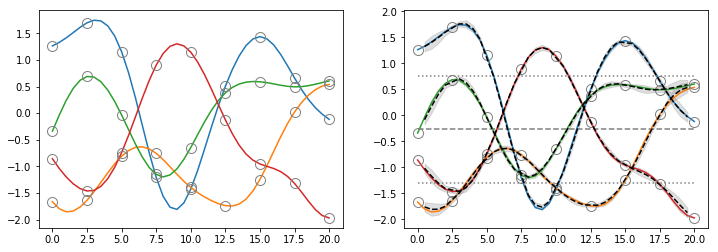

In [9]:
fig,ax1,ax2 = p1.plot_toy_data_and_fits()

Comments: 



### Model checking with the training data only

rjf_no_shift_seed_2_samples_4_test


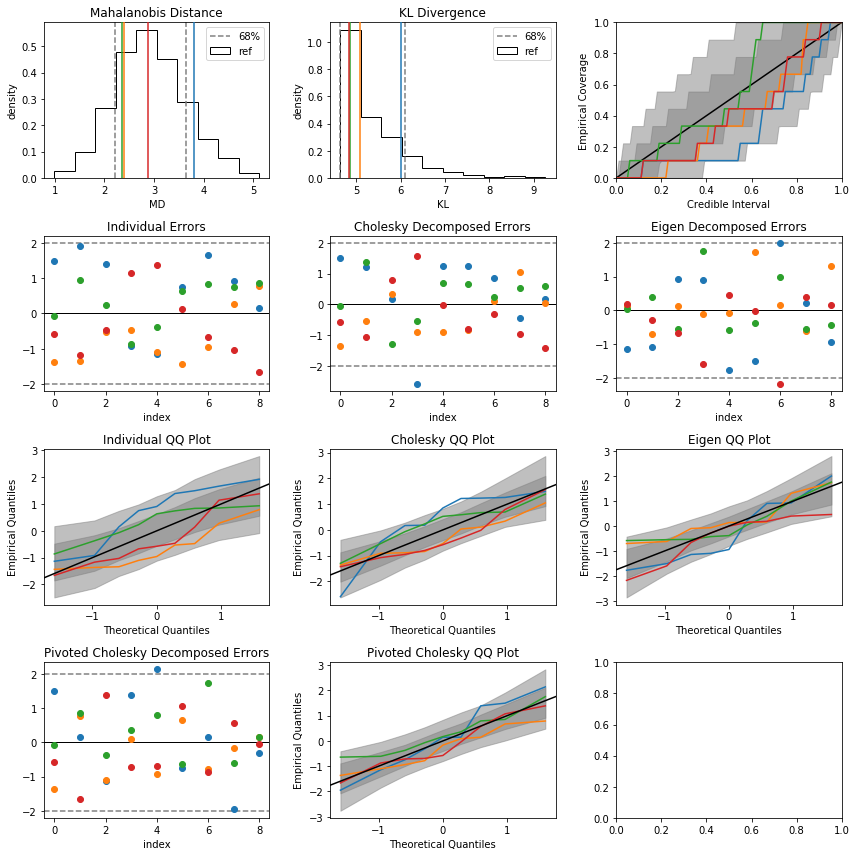

In [10]:
print(p1.name)
p1.model_checking_with_training_data_only()

Comments: 



### Use the test dataset

rjf_no_shift_seed_2_samples_4_test


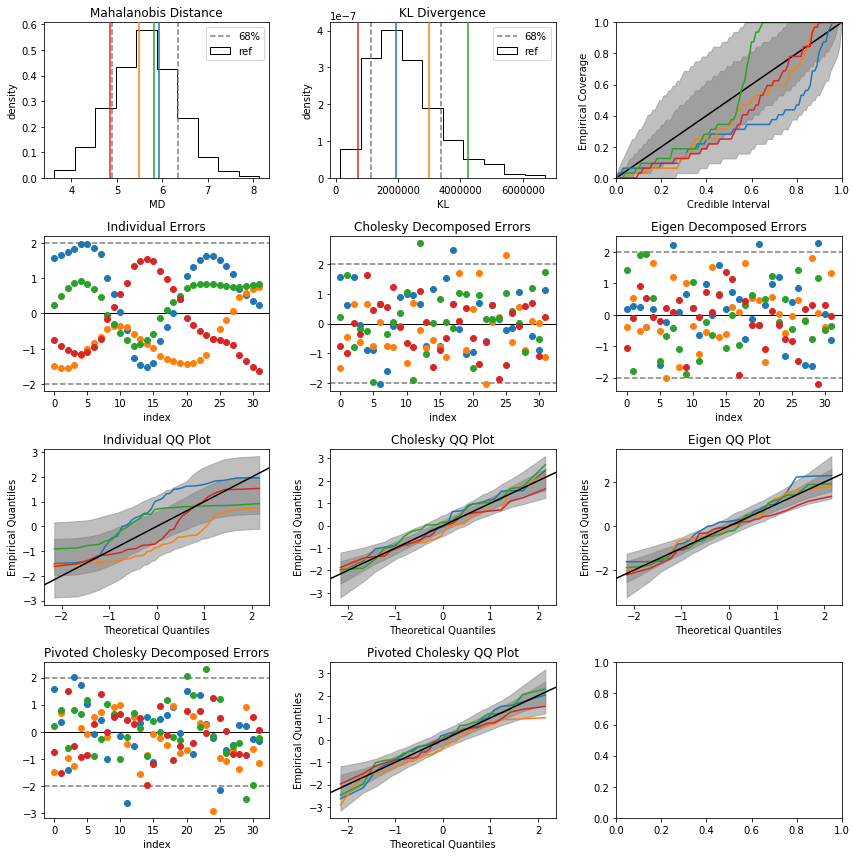

In [11]:
print(p1.name)
p1.model_checking_with_test_data_global()

Comments: 



### Model checking with the interpolants

What if we performed the same model checking with the interpolants?
This time, we are comparing each colored curve to the process defined by the thin gray bands around that curve.
One potential clever way to combine the diagnostics from interpolated processes relies on the fact that the only thing that is different about the interpolating processes is their mean function that interpolates the data. If we subtract the means off the process and the data, then we are back to the simple iid case.

rjf_no_shift_seed_2_samples_4_test


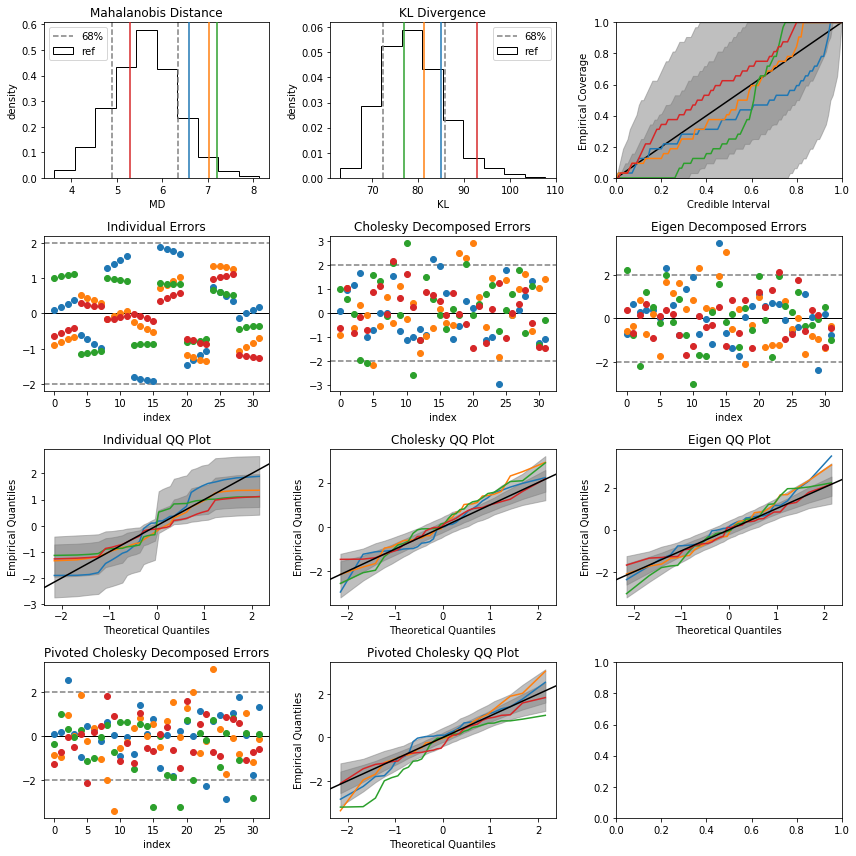

In [12]:
print(p1.name)
p1.model_checking_with_test_data_interpolants()

Comments: 



In [13]:
# *** RUN THIS CELL AFTER YOU HAVE SAVED THE NOTEBOOK ***
# save as a pdf file
output_directory = './saved_notebooks'
output_filename = 'test_file'

!jupyter nbconvert GP_model_checking_test_cases_rjf_upgrade1.ipynb --to pdf \
                  --output-dir=$output_directory --output $output_filename \
                  >/dev/null 2>&1